<a href="https://colab.research.google.com/github/michalszczecinski/data-driven-notebooks/blob/master/electronics/electrical_technology_project_energy_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Code Set Up

In [ ]:
#@title Imports {display-mode: "form"}
import sys
import os
import platform
import random
import itertools
import math
import datetime

import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# reading google sheets files
import gspread
from oauth2client.client import GoogleCredentials

from collections import OrderedDict

# print versions
print (f"system: {sys.version}")
print (f"pandas: {pd.__version__}")
print (f"numpy: {np.__version__}")

system: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
pandas: 1.1.5
numpy: 1.19.5


In [ ]:
# @title Dislay settings  {display-mode: "form"} 
sns.set(context='notebook', style="whitegrid", rc={"figure.figsize": (20, 10)})
pd.set_option("display.float_format", '{:.3f}'.format)
pd.set_option("display.max_rows", 120)
# pd.set_option("display.max_columns", 120)
# pd.set_option("max_colwidth", 200)
pd.set_option('display.expand_frame_repr', False)

### Helper functions and snippets

In [ ]:
# @title Google Authentication {display-mode: "form"}
from google.colab import auth
auth.authenticate_user()

In [ ]:
# @title Loading data from gsheet {display-mode: "form"} 
# importing data from google sheet
def get_data_gsheet(name='data_jobs_summary'):
  gc = gspread.authorize(GoogleCredentials.get_application_default())
  worksheet = gc.open(name).sheet1
  # get_all_values gives a list of rows.
  rows = worksheet.get_all_values()
  header = rows[0]
  df_data = pd.DataFrame.from_records(data=rows[1:], columns=header)
  return df_data

In [ ]:
# @title {display-mode: "form"} 
def generate_header(author='unknown', title='unknown', description ='unknown', prepared_for='unknown', tags=''):
    """
    desc: generates standard header with meta information describing report
    input: author, title, description, prepared_for, tags
    output: rendering formatted dataframe with report details
    """
    meta_dict = OrderedDict()

    # properties to fill
    meta_dict['author'] = author
    meta_dict['title'] = title
    meta_dict['description'] = description
    meta_dict['prepared_for'] = prepared_for
    meta_dict['tags'] = str(tags)

    # auto generated
    runtime = datetime.datetime
    meta_dict['runtime'] = runtime.now().strftime("%Y-%m-%d %H:%M:%S")
    path = os.getcwd()
    meta_dict['path'] = path
    python_version = platform.python_version()
    meta_dict['python_version'] = python_version
    meta_dict['pandas_version'] = pd.__version__

    df_meta= pd.DataFrame(meta_dict, index=['meta_information']).T
    return df_meta

<a name="cell-header"></a>
# Header: Assignment: ELECTRICITY BILL 

[Link to this Colab](https://colab.research.google.com/drive/1u5eafAQZ8FTyNLmFs5RigT8xJdLHzVvv?usp=sharing)

In [ ]:
# setting up header info
author = 'Michal Szczecinski'
prepared_for ='Assignment'
title = 'ELECTRICITY BILL '
description = 'Do an estimated calculation for the electricity bill of your house in one month (30 days). '
tags = ['#electrical_technology', '#project']
generate_header(author=author, title=title, description=description, prepared_for=prepared_for, tags=tags)

,meta_information
author,Michal Szczecinski
title,ELECTRICITY BILL
description,Do an estimated calculation for the electricity bill of your house in one month (30 days).
prepared_for,Assignment
tags,"['#electrical_technology', '#project']"
runtime,2021-07-08 10:22:12
path,/content
python_version,3.7.10
pandas_version,1.1.5


## Problem

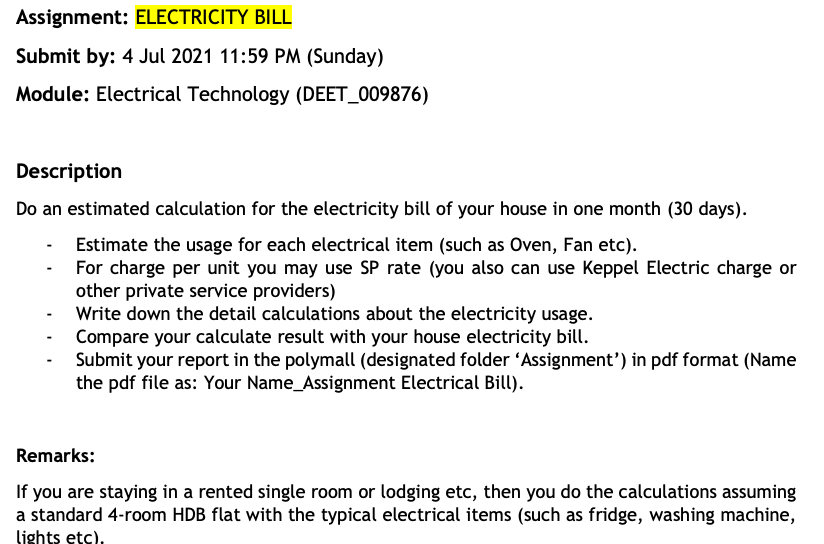

## Configuration

In [ ]:
appliances_data_sheet_name = 'electrical_usage_sheet'
cost_kwh_sgd = 0.2255
days_in_month = 30
# realistic energy usage of the device depends on many factors, including environment, intensity of use, energy saving and standby modes
# in order to control for that I am introducing balancy constant here which can be analysed and modified when needed
# TODO with more empirical data we could introduce separate constants for different types of devices
energy_saving_balancing_constant = 0.4
# metric used for estimations
metrics_results = ['monthly_power_consumption_kw','monthly_cost_sgd', 'monthly_power_consumption_kw_balanced', 'monthly_cost_sgd_balanced']

## Assumptions used

In [ ]:
df_config = pd.DataFrame(data={'appliances_data_sheet_name': appliances_data_sheet_name,
             'cost_kwh_sgd': cost_kwh_sgd,
             'days_in_month': days_in_month,
             'energy_saving_balancing_constant': energy_saving_balancing_constant}, index=['value'])
df_config.T

,value
appliances_data_sheet_name,electrical_usage_sheet
cost_kwh_sgd,0.226
days_in_month,30
energy_saving_balancing_constant,0.400


### Methodology (example)


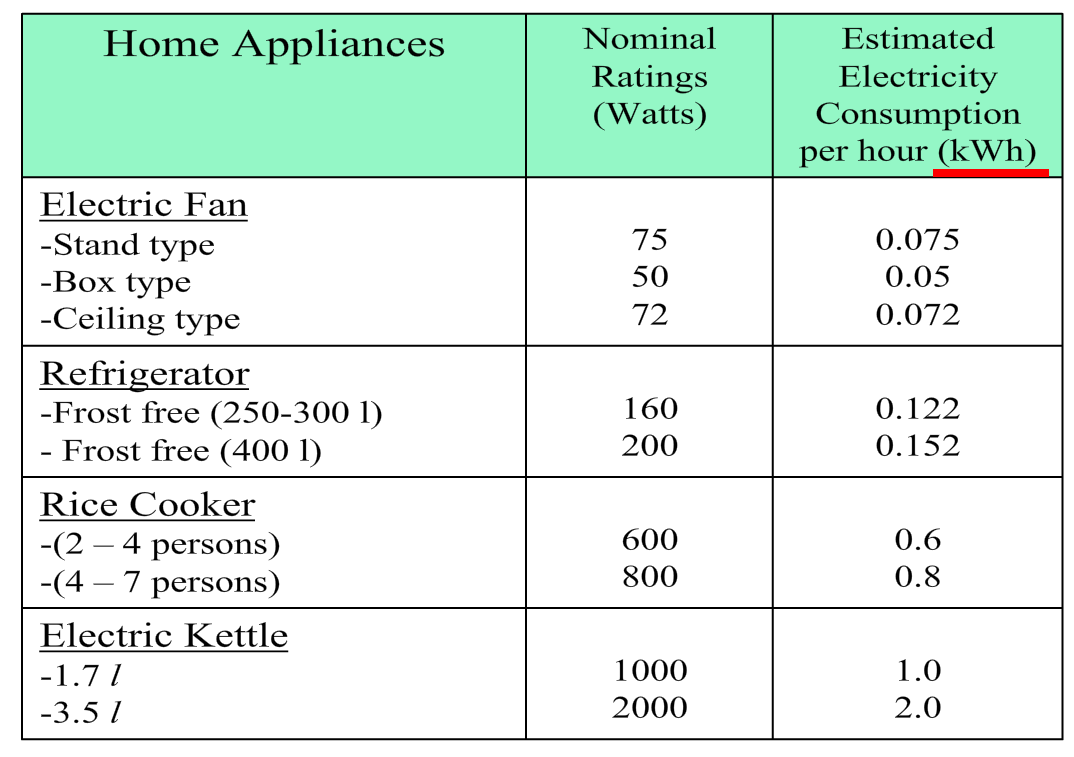

Formulas:

$$
\text{Estimated energy consumption per hour (kWh)} = \frac{\text{Nominal ratings (Watts)}}{1000}
$$

### Reading datasheet with list and specs of appliances

In [ ]:
df_specs = get_data_gsheet(appliances_data_sheet_name)
df_specs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   room                  28 non-null     object
 1   type                  28 non-null     object
 2   home_appliance        28 non-null     object
 3   nominal_rating_watts  28 non-null     object
 4   standby_consumption   28 non-null     object
 5   daily_use             28 non-null     object
 6   comments              28 non-null     object
 7   link                  28 non-null     object
dtypes: object(8)
memory usage: 1.9+ KB


### Calculating metrics with energy usage and cost

Realistic energy usage of the device depends on many factors, including environment, intensity of use, energy saving and standby modes.
In order to control for that I am introducing balancy constant here which can be analysed and modified when needed. 

Summary of the calculation methodology:

1) `daily_power_consumption_kw` = `nominal_rating_watts`/1000 * 'daily_use'

2) `daily_cost_sgd'` = `daily_power_consumption_kw` * cost_kwh_sgd

3) `daily_power_consumption_kw_balanced`  = `daily_power_consumption_kw`  * energy_saving_balancing_constant

4) Monthly metrics are calculated by aggregating daily metrics using assumption of 30 days in a month.

List of columns (of full table)

In [ ]:
df_specs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   room                  28 non-null     object
 1   type                  28 non-null     object
 2   home_appliance        28 non-null     object
 3   nominal_rating_watts  28 non-null     object
 4   standby_consumption   28 non-null     object
 5   daily_use             28 non-null     object
 6   comments              28 non-null     object
 7   link                  28 non-null     object
dtypes: object(8)
memory usage: 1.9+ KB


In [ ]:
# transforming values
df_specs['nominal_rating_watts'] = df_specs['nominal_rating_watts'].astype(float)
df_specs['daily_use'] = df_specs['daily_use'].astype(float)

# calculating energy use
df_specs['monthly_use'] = df_specs['daily_use'] * days_in_month 
df_specs['daily_power_consumption_kw'] = df_specs['nominal_rating_watts']/1000 * df_specs['daily_use']
df_specs['monthly_power_consumption_kw'] = df_specs['nominal_rating_watts']/1000 * df_specs['daily_use'] * 30

#calculating costs
df_specs['daily_cost_sgd'] = cost_kwh_sgd * df_specs['daily_power_consumption_kw']
df_specs['monthly_cost_sgd'] = df_specs['daily_cost_sgd'] * 30

# applying balancing constant
df_specs['daily_power_consumption_kw_balanced']  = df_specs['daily_power_consumption_kw']  * energy_saving_balancing_constant
df_specs['monthly_power_consumption_kw_balanced'] = df_specs['monthly_power_consumption_kw'] * energy_saving_balancing_constant
df_specs['daily_cost_sgd_balanced'] = df_specs['daily_cost_sgd'] * energy_saving_balancing_constant
df_specs['monthly_cost_sgd_balanced'] = df_specs['monthly_cost_sgd'] * energy_saving_balancing_constant

### Summary of equipment and metrics (brief version)
For full details please see appendix of this file in interactive version.

### Summary by appliance

In [ ]:
brief_report_columns = ['home_appliance','nominal_rating_watts','daily_use','daily_power_consumption_kw','daily_power_consumption_kw_balanced','daily_cost_sgd','daily_cost_sgd_balanced']
df_specs[brief_report_columns].set_index('home_appliance')

,nominal_rating_watts,daily_use,daily_power_consumption_kw,daily_power_consumption_kw_balanced,daily_cost_sgd,daily_cost_sgd_balanced
home_appliance,,,,,,
aircon,2500.000,10.000,25.000,10.000,5.638,2.255
dyson_desk_lamp,21.000,3.000,0.063,0.025,0.014,0.006
workshop_lamp,12.000,2.000,0.024,0.010,0.005,0.002
dyson_fan,60.000,24.000,1.440,0.576,0.325,0.130
samsung_34,180.000,10.000,1.800,0.720,0.406,0.162
benq_32,220.000,10.000,2.200,0.880,0.496,0.198
mb_work_16,96.000,8.000,0.768,0.307,0.173,0.069
mb_personal_16,96.000,3.000,0.288,0.115,0.065,0.026
ceiling_light,100.000,4.000,0.400,0.160,0.090,0.036


### Total monthly summary

In [ ]:
pd.DataFrame(df_specs[metrics_results].sum(), columns=['value'])

,value
monthly_power_consumption_kw,2211.426
monthly_cost_sgd,498.677
monthly_power_consumption_kw_balanced,884.570
monthly_cost_sgd_balanced,199.471


### Monthly summary by room

In [ ]:
df_specs.groupby('room')[metrics_results].sum().sort_values('monthly_cost_sgd', ascending=False)

,monthly_power_consumption_kw,monthly_cost_sgd,monthly_power_consumption_kw_balanced,monthly_cost_sgd_balanced
room,,,,
office,970.290,218.800,388.116,87.520
bedroom,777.090,175.234,310.836,70.094
living_room,218.046,49.169,87.218,19.668
bathroom_1,126.000,28.413,50.400,11.365
bathroom_2,120.000,27.060,48.000,10.824


### Monthly summary by type of appliance

In [ ]:
df_specs.groupby('type')[metrics_results].sum().sort_values('monthly_cost_sgd', ascending=False)

,monthly_power_consumption_kw,monthly_cost_sgd,monthly_power_consumption_kw_balanced,monthly_cost_sgd_balanced
type,,,,
aircon,1575.000,355.163,630.000,142.065
water,240.000,54.120,96.000,21.648
screen,120.000,27.060,48.000,10.824
sport,75.429,17.009,30.171,6.804
fan,64.800,14.612,25.920,5.845
food,35.860,8.086,14.344,3.235
light,34.500,7.780,13.800,3.112
computer,31.680,7.144,12.672,2.858
connectivity,10.800,2.435,4.320,0.974


## Electricity Bill (Actual)

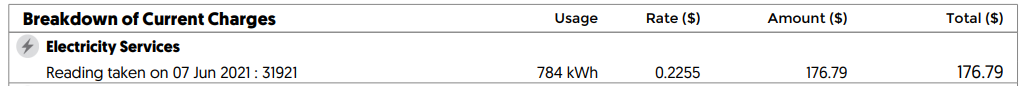

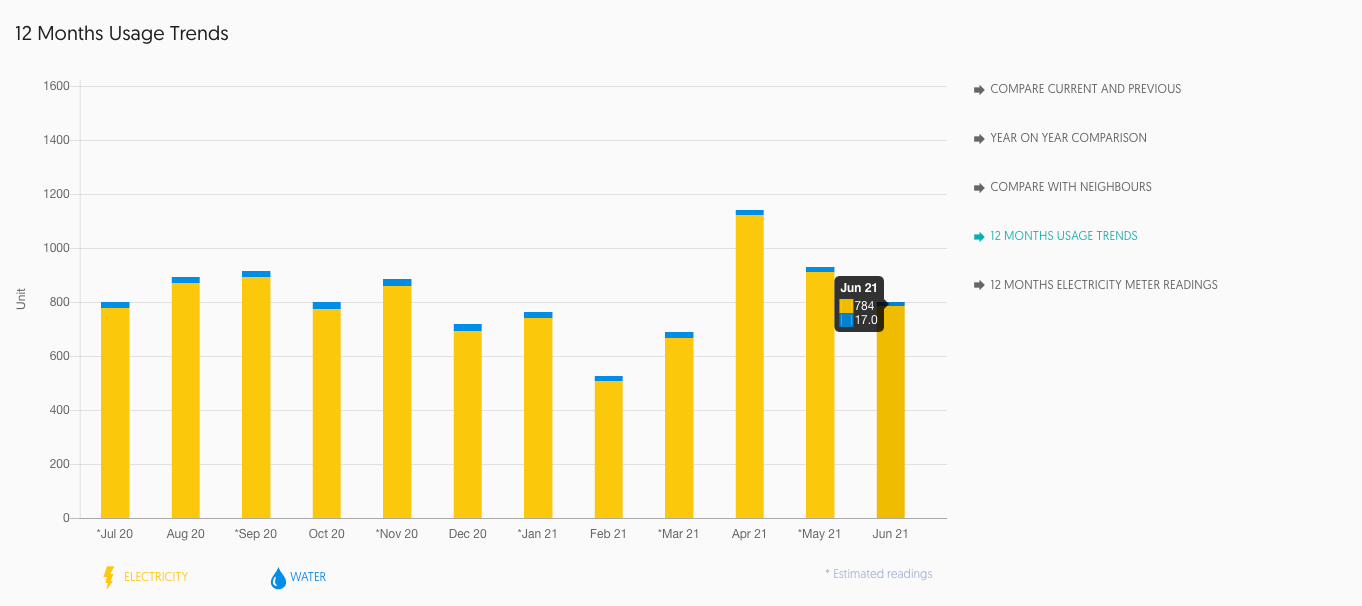

## References

[Appliance power consumption baselines](https://www.daftlogic.com/information-appliance-power-consumption.htm)

[Energy Saving Tips](https://iswitch.com.sg/rising-electricity-bills-consume-electricity/)

## Appendix

### Full report table

In [ ]:
df_specs

,room,type,home_appliance,nominal_rating_watts,standby_consumption,daily_use,comments,link,monthly_use,daily_power_consumption_kw,monthly_power_consumption_kw,daily_cost_sgd,monthly_cost_sgd,daily_power_consumption_kw_balanced,monthly_power_consumption_kw_balanced,daily_cost_sgd_balanced,monthly_cost_sgd_balanced
0,office,aircon,aircon,2500.000,,10.000,,https://adept.sg/products/daikin-system-1-inverter-rks25gvmg-ftks25dvm-9000-btu,300.000,25.000,750.000,5.638,169.125,10.000,300.000,2.255,67.650
1,office,light,dyson_desk_lamp,21.000,0.5,3.000,taking usage from under the lamp,https://www.dyson.com.sg/for-business/lighting/dyson-lightcycle-desk,90.000,0.063,1.890,0.014,0.426,0.025,0.756,0.006,0.170
2,office,light,workshop_lamp,12.000,,2.000,taking usage from under the device,,60.000,0.024,0.720,0.005,0.162,0.010,0.288,0.002,0.065
3,office,fan,dyson_fan,60.000,,24.000,,https://askinglot.com/how-much-electricity-does-a-dyson-air-purifier-use,720.000,1.440,43.200,0.325,9.742,0.576,17.280,0.130,3.897
4,office,screen,samsung_34,180.000,,10.000,,https://www.samsung.com/sg/monitors/ultra-wide/thunderbolt-tm-3-curved-monitor-with-21-9-wide-screen-34-inch-lc34j791wtexxs/,300.000,1.800,54.000,0.406,12.177,0.720,21.600,0.162,4.871
5,office,screen,benq_32,220.000,,10.000,,https://www.benq.com/en-sg/monitor/designer/pd3220u/specifications.html,300.000,2.200,66.000,0.496,14.883,0.880,26.400,0.198,5.953
6,office,computer,macbook_work_16,96.000,5,8.000,,"https://www.quora.com/How-many-watts-of-power-does-the-latest-MacBook-Pro-use#:~:text=The%20TDP%20of%20the%204,3.4W%20and%209W%20respectively.https://www.apple.com/sg/macbook-pro-16/specs/,",240.000,0.768,23.040,0.173,5.196,0.307,9.216,0.069,2.078
7,office,computer,macbook_personal_16,96.000,5,3.000,,https://www.apple.com/sg/macbook-pro-16/specs/,90.000,0.288,8.640,0.065,1.948,0.115,3.456,0.026,0.779
8,office,light,ceiling_light,100.000,,4.000,,,120.000,0.400,12.000,0.090,2.706,0.160,4.800,0.036,1.082
9,office,connectivity,wifi,15.000,,24.000,,https://support.google.com/wifi/answer/6280668?hl=en&ref_topic=6246512#zippy=%2Cgoogle-nest-wifi-tech-specs%2Cgoogle-nest-wifi-router,720.000,0.360,10.800,0.081,2.435,0.144,4.320,0.032,0.974


In [ ]:
# @title Converting and exporting output {display-mode: "form"} 
# uncomment sections one at a time

# installs for converting to pdf
# !apt-get install texlive texlive-xetex texlive-latex-extra pandoc
# !pip install pypandoc

# mount drive to access .ipynb file
# from google.colab import drive
# drive.mount('/content/drive')

# covert and export output 
!cp 'drive/My Drive/Colab Notebooks/eng_electrical_technology_project_energy_usage.ipynb' ./
!jupyter nbconvert --to HTML --no-input "eng_electrical_technology_project_energy_usage.ipynb"
# !jupyter nbconvert --to HTML "eng_electrical_technology_project_energy_usage.ipynb"

[NbConvertApp] Converting notebook eng_electrical_technology_project_energy_usage.ipynb to HTML
[NbConvertApp] Writing 699184 bytes to eng_electrical_technology_project_energy_usage.html
